In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math
import time

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
from skopt import gp_minimize
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=6, suppress=True)

In [2]:
race_type = 'G'

In [3]:
engine = create_engine('sqlite:///data/race.db')
conn = engine.connect()
conn
dfoo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfoo)))

38673 races loaded!


In [4]:
dfo = dfoo.loc[dfoo['race_type'].isin([race_type])]
print('{} {} races!'.format(len(dfo), race_type))

16501 G races!


In [5]:
dfo = dfo[dfo['num_runners'] == 8]
print('{} of 8 runners races!'.format(len(dfo)))

11107 of 8 runners races!


In [6]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.head(3)

,id,meeting_name,location,venue_mnemonic,race_type,meeting_date,race_number,race_name,race_start_time,race_status,race_distance,results_data,num_runners,runners_data,quinella,exacta,trifecta,first_four,results,runners
11,16,CANBERRA,ACT,C,G,2017-10-01,1,THE CLIMATE DOCTOR MAIDEN,2017-10-01 05:57:00,Paying,310,"[[1], [7], [2], [3]]",8.0,"[{""runnerName"": ""SUTTON LEWIS"", ""runnerNumber""...",2.1,3.6,15.3,72.0,"[[1], [7], [2], [3]]","[{'runnerName': 'SUTTON LEWIS', 'runnerNumber'..."
13,20,CANBERRA,ACT,C,G,2017-10-01,5,TAB WE LOVE A BET STAKES,2017-10-01 07:18:00,Paying,530,"[[4], [6], [8], [5]]",8.0,"[{""runnerName"": ""UNCHANGEABLE"", ""runnerNumber""...",24.5,21.4,75.0,479.3,"[[4], [6], [8], [5]]","[{'runnerName': 'UNCHANGEABLE', 'runnerNumber'..."
14,23,CANBERRA,ACT,C,G,2017-10-01,8,CANBERRA TO BULLI 1-3 HEAT2,2017-10-01 08:29:00,Paying,440,"[[3], [1], [4], [8]]",8.0,"[{""runnerName"": ""CLEO PARKER"", ""runnerNumber"":...",2.3,2.9,9.2,48.2,"[[3], [1], [4], [8]]","[{'runnerName': 'CLEO PARKER', 'runnerNumber':..."


In [7]:
data = []
for _, race in dfo.iterrows():
#     print(race)
#     print(race['runners'])
    runners = [r for r in race['runners'] if r['has_odds']]
    runners = sorted(runners, key=itemgetter('win_odds'))
    win_scales = [r['win_scaled'] for r in runners]
    poly = np.polyfit(win_scales, np.arange(8) + 1, 2)
    for i, r in enumerate(runners):
#         print('#{} {} {}'.format(r['runnerNumber'], r['finishingPosition'], r['win_odds']))
        success = r['finishingPosition'] == 1
        div = r['win_odds'] if success else 0
        item = {
            'pos': i + 1,
            'odds': r['win_odds'],
            'perc': r['win_perc'],
            'success': int(success),
            'profit': -1 + div,
            'poly_a': poly[0],
            'poly_b': poly[1],
            'poly_c': poly[2],
        }
        data.append(item)
print(len(data))

88856


In [12]:
df = pd.DataFrame(data)
df.tail()

,odds,perc,poly_a,poly_b,poly_c,pos,profit,success
88851,7.8,0.128205,104.881984,-61.900904,10.072535,4,-1.0,0
88852,8.6,0.116279,104.881984,-61.900904,10.072535,5,-1.0,0
88853,10.4,0.096154,104.881984,-61.900904,10.072535,6,-1.0,0
88854,12.1,0.082645,104.881984,-61.900904,10.072535,7,-1.0,0
88855,28.8,0.034722,104.881984,-61.900904,10.072535,8,-1.0,0


In [13]:
# groups_pos = df.groupby(df['pos']).mean()
# print(groups_pos)
# groups_pos.plot(kind='bar', y='success', title='Avg win rate per pos')
# groups_pos.plot(kind='bar', y='perc', title='Avg perc rate per pos')
# groups_pos.plot(kind='bar', y='profit', title='Avg profit rate per pos')


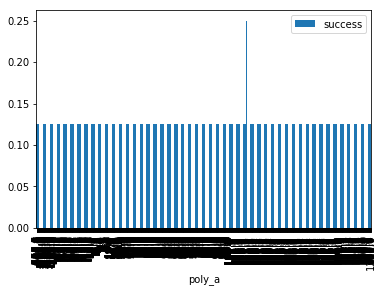

In [14]:
dfa = df[df['pos'] == 1]
# groups = df.groupby(df['success']).mean()
# groups.plot(kind='bar', y='poly_a', title='poly a')
# groups.plot(kind='bar', y='poly_b', title='poly b')
# groups.plot(kind='bar', y='poly_c', title='poly c')

groups = df.groupby(df['poly_a'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='success', title='')
